# MetricGAN: Speech Enhancement

*(MetricGAN: Generative Adversarial Networks based Black-box Metric Scores
Optimization for Speech Enhancement. **Szu-Wei Fu et al.**)*

*Paper on arxiv: https://arxiv.org/pdf/1905.04874.pdf*

---

## Dataset

В этой работе мы будем брать высказывания из TIMIT, портить их разными видами шума, и восстанавливать с помощью `MetricGAN`.

В статье указаны далеко не все параметры и методы, которыми был получен их результат. Но мой получился вполне сопоставим с их.

Данные я постарался создать максимально близкие к статье:

**Train set:**
- Speech: 300 случайных реплик из TIMIT train.
- Noise: 10 типов шума из [PNL 100 Nonspeech Sounds](http://web.cse.ohio-state.edu/pnl/corpus/HuNonspeech/HuCorpus.html) (здесь все ок, типы шумов в статье совпадают с теми, что есть в датасете Nonspeech)
- Смешивание на 5 уровнях громкости (SNR level) -8, -4, 0, 4, 8 dB. (смешиваются каждый спич с каждым шумом на каждом SNR)
- ИТОГО: 15к, ~25 часов

**Test set:**
- Speech: 100 случайных реплик из TIMIT test.
- Noise: 4 типов шума из [PNL 100 Nonspeech Sounds](http://web.cse.ohio-state.edu/pnl/corpus/HuNonspeech/HuCorpus.html) (здесь в статье взяты типы (engine, white, street, and baby cry), таких нет в Nonspeech датасете. Я взял что-то похожее из того что было в Nonspeech. Например в нем нет baby cry, но есть просто cry, но он далеко не baby)
- Смешивание на 5 уровнях громкости (SNR level) -12, -8, 0, 8, 12 dB
- ИТОГО: 2к, ~3.3 часа

## Preprocessing

Эта часть почти не раскрыта в статье. Поэтому я попробовал разные способы предобработки.

1. Изначально я поставил цель просто обучить любым способом, чтобы получить какой-то бэйзлайн. Я делал stft с n_fft=512, преобразовывал в dB scale и нормировал в пределы, близкие к \[-1, +1\] (это похоже на MinMax норм, но не свосем).

2. Второй способ, который я попробовал - в амплитудной шкале. stft с n_fft=512, затем сразу нормализация mean-std по временной оси. Этот способ я решил попробовать, потому что, как я потом выяснил, именно он использовался авторами статьи.

Сразу скажу, что все результаты получились примерно равными и близки к тем, что получиличь у авторов.

Помимо спектрограмм зашумленного и чистого сигналов, я также сохранял **фазы** и **.wav** файлы, чтобы можно было восстановить сигнал и послушать, сравнить с версией без enhancing.

Итоговый вес датасета получился **~24 ГБ**.

## Model: MetricGAN

Интересная особенность этой GAN модели в том, что здесь мы пытаемся оптимизировать нужную нам метрику, по которой и хотим приблизиться к оптимальному значению. Эта метрика, особенно в случае аудио-сигналов, часто бывает сложным и недифференцируемым алгоритмом, например, **PESQ** или **STOI**. Я смотрел как вычисляется PESQ, там действительно очень огромный и сложный алгоритм, который еще и считается ~40 ms на 1 сек wav файла, причем реализовано на C.

Основная идея лежит в Дискриминаторе. Он будет стремится стать диффиренцируемым эквивалентом этой функции и сможет примерно предсказывать метрику (На самом деле это не совсем так, его веса оптимизируются только в зависимости от Генератора, и на практике Дискриминатор не будет хорошо прогнозировать метрику).

**Для этого нам нужно сформировать правильные лосс-функции.**

Мы хотим, чтобы веса Генератора оптимизоровались так, чтобы, сделав шаг градиента Генератора, текущий Дискриминатор выдал бы скор ближе к 1.

Дискриминатор, в свою очередь, делает шаг, чтобы, во-первых учиться отличать fake от real (здесь noisy от clean), и, во-вторых, учиться оценивать то, что сгенерировал Генератор, тем самым, заставляя его генерировать распределение более близкое к denoised звуку (точнее, более близкое с точки зрения выбранной функции-метрики).

Также мы будем штрафовать Генератор, если его спектрограмма будет сильно отличаться от незашумленного референса. Это поможет предотвратить всякие искажения и артефакты в звуке.

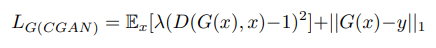

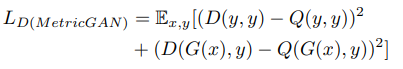

*Метрика Q принимает на вход **clean** и **noisy** сигналы, сравнивает их, и говорит, **насколько noisy плох, в отличие от clean референса**.*

*Q(y,y) всегда будет 1.0, можно заменить этот term на 1 и не делать лишния вычисления.*

Мы хотим от Дискриминатора, чтобы он принимал 2 спектрограммы - clean и noisy, и оценивал наскольо noisy плох по сравнению с clean.

Также с этой моделью нам теперь не обязательно стремиться к скору 1.0, решая задачу максимизации. Мы можем выбрать любое другое число и обучать генератор генерить ровно на нужный нам скор (хотя, наверное, это пока не слишком полезно на практике).

## Architecture Details

**SpectralNormalization:**

В статье используется **SpectralNormalization**. Не буду подробно его рассматривать, т.к. на это может уйти целая отдельная статья, например как эта [GAN — Spectral Normalization](https://medium.com/@jonathan_hui/gan-spectral-normalization-893b6a4e8f53). Эта нормализация - небольшая корректировка весов слоя перед forward pass помогает - GAN'ам стабильнее обучаться:

Я использовал готовую реализацию для PyTorch: [\(git\) spectral_normalization.py](https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/spectral_normalization.py)

Также пробовал обучить и без нее, по ощущениям разница небольшая, мне показалось, что просто немного быстрее сходится.

**MetricGAN:**

Я попробовал несколько разных архитектур, все в принципе отработали +- одинково. Вот одна из последних, которые я обучал:

**Основыне изменения:**
- G: увеличил hidden_size c 200 до 300.
- D: использую только 3х3 и 5х5 свертки, больше каналов, stride=2 (у авторов 1).

**Generator:**

- BiLSTM(300)
- BiLSTM(300)
- Linear(300), LeakyRELU
- Linear(257), Sigmoid

**Discriminator:**

- Conv2dSN(10, (5,5), stride=2), LeakyRELU
- Conv2dSN(20, (3,3), stride=2), LeakyRELU
- Conv2dSN(40, (3,3), stride=2), LeakyRELU
- Conv2dSN(80, (3,3), stride=2), LeakyRELU
- GlobalAvgPool2D()
- Linear(40), LeakyRELU
- Linear(1)

**Hyperparameters:**

- num_epochs = 7
- batch_size = 25
- s = 1.0 (target metric value)
- λ = 0.01
- weights_init: xavier (glorot)
- optimizer: Adam
- lr: 2e-4
- LeakyReLU_slope: 0.2

---

## Train History

In [4]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14,5)
plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['axes.grid'] = False

losses_stoi = torch.load('src/output/losses_metricGAN_alldata_1_mul_sigm_sn_truenorm_stride_STOI_e7')
dq_hist_stoi = torch.load('src/output/dq_hist_metricGAN_alldata_1_mul_sigm_sn_truenorm_stride_STOI_e7')
losses_pesq = torch.load('src/output/losses_metricGAN_alldata_1_mul_sigm_sn_truenorm_stride_PESQ_e7')
dq_hist_pesq = torch.load('src/output/dq_hist_metricGAN_alldata_1_mul_sigm_sn_truenorm_stride_PESQ_e7')

### STOI

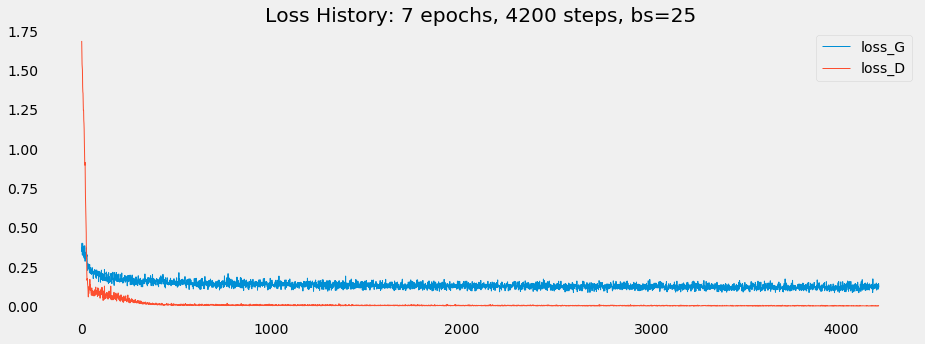

In [5]:
pd.DataFrame(losses_stoi, columns=['loss_G', 'loss_D']).plot()
plt.title('Loss History: 7 epochs, 4200 steps, bs=25');

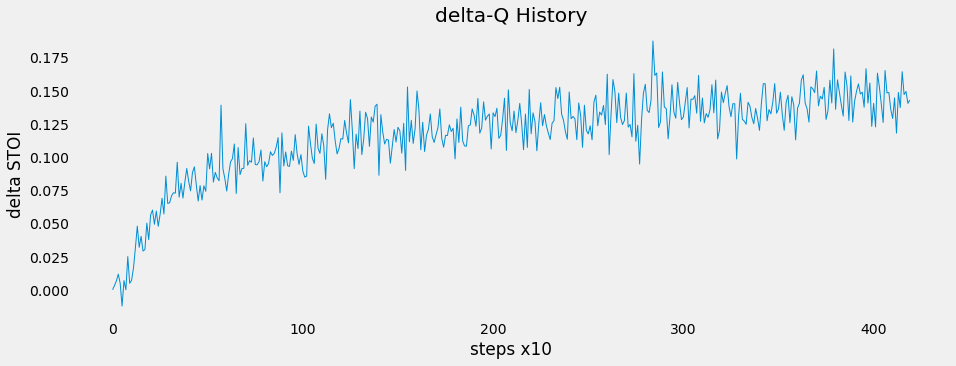

In [6]:
plt.plot(dq_hist_stoi)
plt.title('delta-Q History')
plt.xlabel('steps x10')
plt.ylabel('delta STOI');

$$Q_{delta} = Q (clean, enhanced) - Q (clean, noisy)$$

**<center>На графике delta-Q - это разница между качеством noisy и enhanced сигналов. Это ключевой показатель эффективности модели.</center>**
**<center>Если значение отрицательное, значит модель только ухудшает сигнал.</center>**

### PESQ

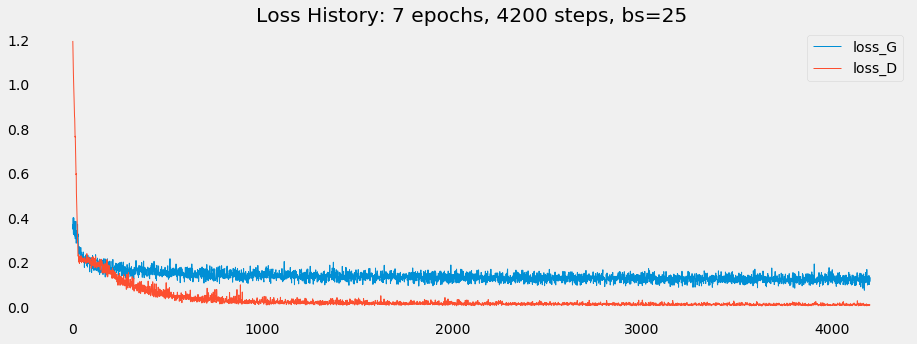

In [7]:
pd.DataFrame(losses_pesq, columns=['loss_G', 'loss_D']).plot()
plt.title('Loss History: 7 epochs, 4200 steps, bs=25');

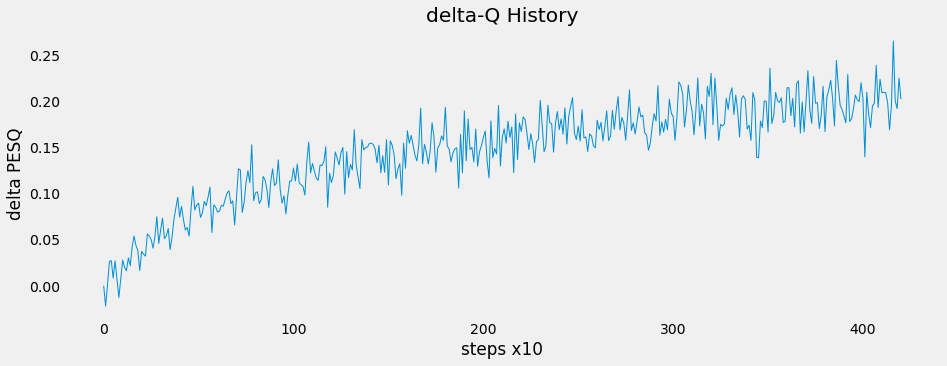

In [8]:
plt.plot(dq_hist_pesq)
plt.title('delta-Q History')
plt.xlabel('steps x10')
plt.ylabel('delta PESQ');

## Results

In [9]:
res_authors = torch.load('results_authors.df')
res_my = torch.load('results_my.df')

In [11]:
pd.set_option('display.precision', 3)
print('Authors:')
res_authors

Authors:


Noisy        MetricGAN (P) MetricGAN (S)
          PESQ   STOI          PESQ          STOI
SNR, dB                                          
12       2.375  0.919         2.967         0.939
6        1.963  0.831         2.616         0.885
0        1.589  0.709         2.200         0.802
-6       1.242  0.576         1.711         0.679
-12      0.971  0.473         1.169         0.533
Avg.     1.628  0.702         2.133         0.768

In [12]:
print('My:')
res_my

My:


Noisy        MetricGAN (P) MetricGAN (S)
          PESQ   STOI          PESQ          STOI
SNR, dB                                          
12       1.704  0.923         2.137         0.942
6        1.361  0.845         1.629         0.883
0        1.183  0.734         1.318         0.789
-6       1.099  0.605         1.163         0.665
-12      1.077  0.483         1.087         0.526
Avg.     1.285  0.718         1.467         0.761

C STOI получилось практически как в статье, при том, что обучал всего 7 эпох. В статье не указано сколько они обучали, а в коде у них num_epochs = 200

C PESQ выглядит немного попохуже. Думаю здесь 7 эпох явно было мало, это видно по графику delta-Q выше. А еще Noisy файлы в моей тестовой выборке получились гораздо сложнее по PESQ метрике, чем у них (1.28 против 1.63).

## Бонус

**А еще я заметил в коде авторов небольшой баг.**

Чтобы эксперимент получился близким к статье, я очень внимательно изучал официальный код на гитхабе от авторов статьи ([git](https://github.com/JasonSWFu/MetricGAN)), потому что в статье многие детали и параметры упущены.

Код у них, конечно, не очень презентабельный и представляет из себя 1 большой файл, где все набито в кучу, а переменные и функции названы непонятными и странными именами. Написано на python 2, и еще используются какая-то старая версия Keras.

Но я заметил у них небольшой баг:

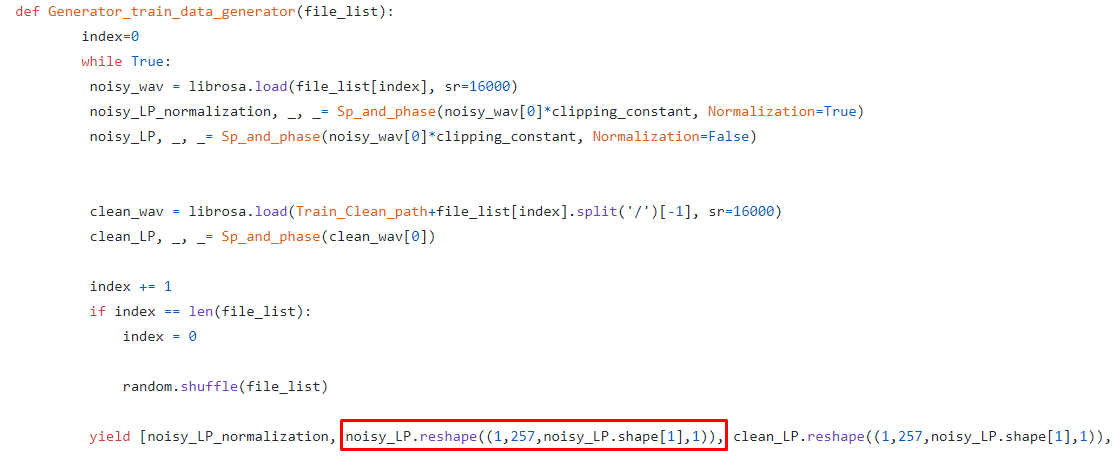

Вместо решейпа правильнее было бы сначало переместить оси, например `torch.permute(0,2,1,3)`. Иначе данные смешиваются между осями.

У них получаются такие спектрограммы (перевел в dB для наглядности):
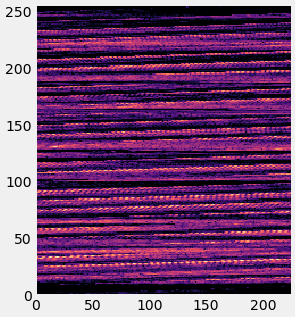
Вместо таких:
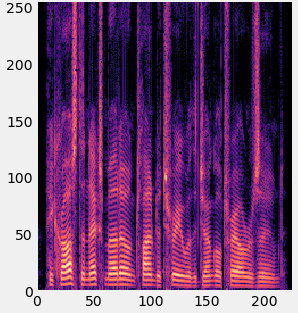

И да, модель на них и обучалась, и я даже понял почему это ей не помешало обучиться - потому что там в пайплайне в модели удачно они везде работают с такой спектрограммой, и маска получается такой же, а на evaluate стадии они делали преобразование спектрограмм вручную, без этой функции. И тоже сделали reshape с перемешиванием осей, который получился как бы обратной функцией к тому неправильному решейпу.

**Получается интересный вывод**: от порядка пикселей в картинке она остается все той же картинкой, а данные остаются данными =)

## Архитектура + вместо x

Также я попробовал немного поэкспериментировать с моделью.

В статье предлагается создавать enhanced спектрограмму путем умножения сгенерированной маски на зашумленную спек-у. Когда я работал с dB шкалой, которую нормализовал в \[-1, 1\], я попробовал сделать в конце Tanh вместо Sigmoid, чтобы сеть могла не только пропорцианаольно глушить неоторый сигнал, но и увеличивать его части, и вообще влиять на неё прямым образом - сложением. Дело в том, что если маска от 0 до 1, то модель не может увеличивать сигнал, только уменьшать или оставлять таким же. Сложение же ползволяет создавать более гибкие маски.

Я протестировал её сначала на маленьком датасете из 2к сэмплов вместо 15к, такая модель показала более быструю сходимость, чем предыдущая с умножением. Однако, на всем 15к датасете это все же не сыграло большой роли. Итоговый скор (средний по тесту) получился 0.7599, вместо 0.7610.

## Как еще можно делать Speech Enhancement?

Область для экспериментов здесь очень большая. Помимо генеративных моделей можно использовать различные модели **encoder-decoder**, по типу **SegNet/U-Net**, в декодере можно использовать как **upsampling**, так и **ConvTranspose**, и **dilated** свертки. Также популярным способом является **Autoencoder, VAE, CVAE**, где можно влиять на latent space и генерировать conditioanal спектрограммы. Можно посмотреть в сторону **Transformer-based** моделей и использовать **attention**. А вместо спектрограмм можно работать напрямую с wav, например, как в **WaveNet** от deepmind.

## Часть 2. Статья

За последний год мне очень понравилась статья [On the Measure of Intelligence](https://arxiv.org/abs/1911.01547) от создателя Keras, François Chollet. В этой статье он предлагает немного посмотреть в ближайшее будущее, которое, благодаря подобным статьям может стать настоящим. Атор предлагает рассмотреть 